---

<h2 style="text-align: center;"><b>Перцептрон Розенблатта<br><br></b></h2>

---

В данном ноутбуке мы:  

- реализуем класс **`Perceptron()`** -- нейрон пороговой функцией активации
- обучим и протестируем перцептрон на сгенерированных и реальных данных (файлы с реальными данными помещены в папку /data в этой же директории)
- сравним качество работы Вашего класса с классом из библиотеки `scikit-learn` (`sklearn.linear_model.Perceptron()`)

<h2 style="text-align: center;"><b>Введение</b></h2>

Почти любой алгоритм машинного обучения, решающий задачу *классификации* или *регрессии*, работает так:

1. (*стадия инициализации*) Задаются его **гиперпараметры**, то есть те величины, которые не "выучиваются" алгоритмом в процессе обучения самостоятельно 
2. (*стадия обучения*) Алгоритм запускается на данных, **обучаясь** на них и меняя свои **параметры** (не путать с *гипер*параметрами) каким-то определённым образом (например, с помощью *метода градиентного спуска* или *метода коррекции ошибки*), исходя из функции потерь (её называют *loss function*). Функция потерь, по сути, говорит, где и как ошибается модель
3.  (*стадия предсказания*) Модель готова, и теперь с помощью неё можно делать **предсказания** на новых объектах

In [44]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

<h2 style="text-align: center;"><b>Класс Perceptron</b></h2>

В даном разделе будет решаться задача **бинарной классификации** с помощью перцептрона:  
- *Входные данные*: матрица $X$ размера $(n, m)$ и столбец $y$ из нулей и единиц размера $(n, 1)$. Строкам матрицы соответствуют объекты, столбцам - признаки (то есть строка $i$ есть набор признаков (*признаковое описание*) объекта $X_i$).
- *Выходные данные*: столбец $\hat{y}$ из нулей и единиц размера $(n, 1)$ - предсказания алгоритма.

Модель нейрона в биологии и в deep learning:  

![title](http://lamda.nju.edu.cn/weixs/project/CNNTricks/imgs/neuron.png)

Чтобы понять, как мы будем обновлять параметры модели (веса), нужно знать, какую функцию потерь мы оптимизируем (находим минимум). В данном случае мы решаем задачу бинарной классификации (2 класса: 1 или 0), возьмём в качестве функции потерь среднеквадратичную ошибку:  

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (f(w \cdot X_i + b) - y_i)^2$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $f()$ - пороговая функция:  

$$
f(w \cdot X_i + b) =
\begin{cases}
1, &\text{если } w \cdot X_i + b > 0 \\
0, &\text{если } w \cdot X_i + b \le 0
\end{cases}
$$  

**Примечание:** На самом деле можно считать, что $b$ - свободный член - является частью вектора весов: $w_0$, приписав к $X$ слева единичный столбец, тогда в скалярном произведении с каждым объектом $b$ будет именно как свободный член. При реализации класса `Perceptron()` мы будем обновлять $b$ отдельно от $w$.

Реализуем функцию потерь:

In [68]:
def Loss(y_pred, y):
    '''
    Считаем среднеквадратичную ошибку
    '''
    y_pred = y_pred.reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Поскольку у *пороговой функции* не существует производной в нуле, то мы не можем использовать градиентный спуск, ведь:  

$$ \frac{\partial Loss}{\partial w} = \frac{1}{n} X^T\left(f(w \cdot X) - y\right)f'(w \cdot X)$$  

где $f^{'}(w \cdot X)$ -- в точке 0 посчитать не получится. Но хочется как-то обновлять веса, иначе обучения не случиться.

Поэтому предлагается обновлять так:   

$$w^{j+1} = w^{j} - \alpha\Delta{w^{j}}$$ 
$$b^{j+1} = b^{j} - \alpha\Delta{b^{j}}$$ 

где:  

$$\Delta{w} = \frac{1}{n}X^T(\hat{y} - y) = \frac{1}{n}X^T(f(X \cdot w^j + b^j) - y)$$  
$$\Delta{b} = \frac{1}{n}X^T(\hat{y} - y) = \frac{1}{n}1^T(f(X \cdot w^j + b^j) - y)$$  

где $w \cdot X$ - матричное произведение столбца весов $w$ на матрицу объектов-признаков $X$, $1^T$ -- вектор-строка из единиц, а индекс $j$ -- номер итерации градиентного спуска.

Это правило является неким частным случаем градиентного спуска для данного случая (см. *[правило Хебба](https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D0%BB%D1%8C%D1%82%D0%B0-%D0%BF%D1%80%D0%B0%D0%B2%D0%B8%D0%BB%D0%BE)*, *[метод коррекции ошибки](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BA%D1%86%D0%B8%D0%B8_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8)*).

Вооружившись всеми формулами, напишем свой класс **`Perceptron()`**. 

*Примечание*: В коде ниже `y_pred` -- это $\hat{y}$ из формул выше

In [180]:
class Perceptron:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        # Пока что мы не знаем размер матрицы X, а значит не знаем, сколько будет весов
        self.w = w
        self.b = b
        
    def activate(self, x):
        return np.array(x > 0, dtype=np.int64)
        
    def forward_pass(self, X):
        """
        Эта функция рассчитывает ответ перцептрона при предъявлении набора объектов
        :param: X -- матрица объектов размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами перцептрона 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов перцептрона в соответствии с этим объектом
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        self.w = self.w - learning_rate * (X.T @ (y_pred - y) / n)
        self.b = self.b - learning_rate * np.mean(y_pred - y)
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение
        losses = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            # предсказания с текущими весами
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            losses.append(Loss(y_pred, y))
            # обновляем веса в соответсвие с тем, где ошиблись раньше
            self.backward_pass(X, y, y_pred)

        return losses


In [277]:
class my_Perceptron:
    def __init__(self, w=None, b=0):
        # инициализация весов и смещения 
        self.w = w
        self.b = b
        
    
    def activate(self, X):
        # функция активации
        return(np.array(X > 0, dtype = np.int64))
    
    
    def forward_pass(self, X):
        # расчет таргета по имеющимся весам
        n = X.shape[0]
        y_pred = np.zeros((n, 1))
        y_pred = self.activate(X @ self.w.reshape(-1, 1) + self.b)
        return y_pred
    
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.0001):
        # перерасчет весов 
        n = len(y)
        self.w = self.w - learning_rate * (X.T @ (y_pred - y)) / n
        self.b = self.b - learning_rate * np.mean(y_pred - y)
        
        
    def fit(self, X, y, num_epochs=300):
        # функция обучения 
        self.w = np.zeros((X.shape[1],1))
        self.b = 0
        losses = []
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            losses.append(Loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
        
        return losses

Класс готов. Посмотрим, правильно ли ведёт себя Ваш перцептрон. Далее идут несколько ячеек с тестовым кодом, Вам нужно просто запустить их и проверить, чтобы результаты запуска совпадали с соответствующими числами из таблиц:

**Проверка forward_pass():**

In [268]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
X = np.array([[1., 2., -1.], [3., 4., -3.2]])

perceptron = my_Perceptron(w, b)
y_pred = perceptron.forward_pass(X.T)
print ("y_pred = " + str(y_pred))

y_pred = [[1]
 [1]
 [0]]


**Проверка backward_pass():**

In [269]:
y = np.array([1, 0, 1]).reshape(3, 1)

In [270]:
perceptron.backward_pass(X.T, y, y_pred)

print ("w = " + str(perceptron.w))
print ("b = " + str(perceptron.b))

w = [[0.9999 ]
 [1.99976]]
b = 2.0


Посмотрим, как меняется функция потерь в течение процесса обучения на реальных данных - датасет "Яблоки и Груши":

In [271]:
data = pd.read_csv("apples_pears.csv")

In [272]:
data.head()

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yellowness  1000 non-null   float64
 1   symmetry    1000 non-null   float64
 2   target      1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


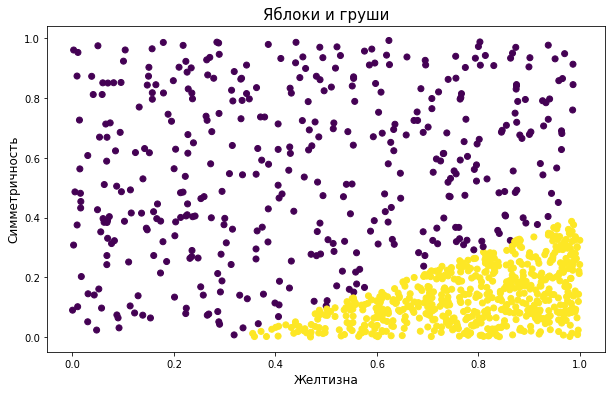

In [274]:
plt.figure(figsize=(10,6))
plt.scatter(x=data.yellowness, y=data.symmetry, c=data.target)
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('Желтизна',fontsize=12)
plt.ylabel('Симметричность', fontsize=12)
plt.show()

**Вопрос:** Какой класс соответствует яблокам (какого они цвета на графике)?

Обозначим, что здесь признаки, а что - классы:

**Вывод функции потерь**  
Функция потерь должна убывать и в итоге стать близкой к 0

In [283]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

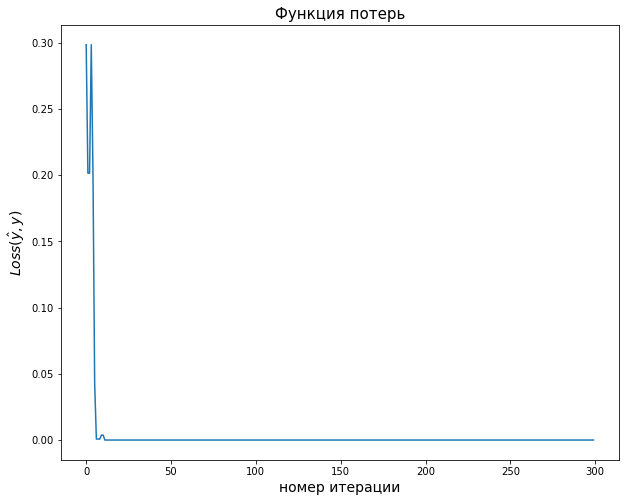

Wall time: 202 ms


In [284]:
%%time
perceptron = my_Perceptron()
losses = perceptron.fit(X_train, y_train)

plt.figure(figsize=(10, 8))
plt.plot(losses)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [285]:
# предскажем для тестовых данных.

from sklearn.metrics import accuracy_score
accuracy_score(y_test, perceptron.forward_pass(X_test))

1.0

Посмотрим, как перцептрон классифицировал объекты из выборки:

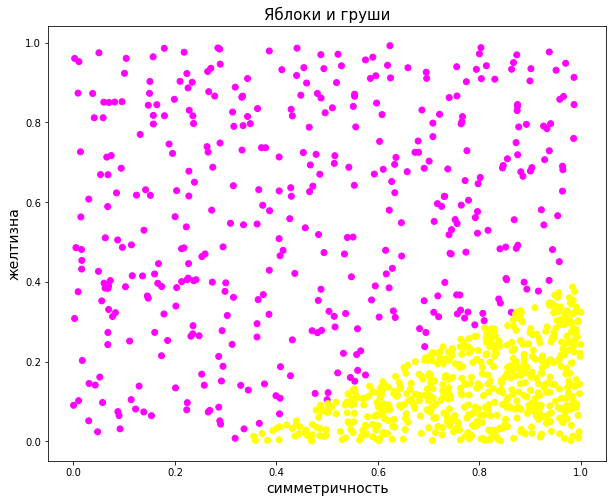

In [208]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=perceptron.forward_pass(X).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Справился идеально. Однако просьба обратить внимание, что это очень простая, *линейно разделимая*, выборка.

<h3 style="text-align: center;"><b>Предсказание пола по голосу</b></h3>

Сравнить качество работы нашего перцептрона и алгоритма из библиотеки `sklearn` на датасете с сайта [Kaggle](https://www.kaggle.com) - [Gender Recognition by Voice](https://www.kaggle.com/primaryobjects/voicegender). В данном датасете в качестве признаков выступают различные звуковые характеристики голоса, а в качестве классов - пол (мужчина/женщина). Подробнее о самих признаках можно почитать [на странице датасета](https://www.kaggle.com/primaryobjects/voicegender) (на английском). Нашей целью пока что является просто протестировать на этих данных два алгоритма.

In [209]:
import pandas as pd
from sklearn.linear_model import Perceptron as skPerceptron
from sklearn.metrics import accuracy_score

In [128]:
data_path = 'voice.csv'
data = pd.read_csv(data_path)
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)

In [129]:
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


In [130]:
# Чтобы перемешать данные. Изначально там сначала идут все мужчины, потом все женщины
data = data.sample(frac=1)

In [132]:
from sklearn.model_selection import train_test_split
X = data.drop(['label'], axis = 1)
y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Натренируем наш перцептрон и перцептрон из `sklearn` на этих данных:

In [133]:
RANDOM_SEED = 42

perceptron = Perceptron()
perceptron.fit(X_train.values, y_train.values)

sk_perceptron = skPerceptron(random_state=RANDOM_SEED)
sk_perceptron.fit(X_train.values, y_train.values)

Perceptron(random_state=42)

Сравним доли правильных ответов (на тестовых данных):

In [134]:
print('Точность (доля правильных ответов, из 100%) нашего перцептрона: {:.3f} %'.format(
    accuracy_score(y_test.values, perceptron.forward_pass(X_test)) * 100))
print('Точность (доля правильных ответов) перцептрона из sklearn: {:.3f} %'.format(
    accuracy_score(y_test.values, sk_perceptron.predict(X_test)) * 100))

Точность (доля правильных ответов, из 100%) нашего перцептрона: 49.044 %
Точность (доля правильных ответов) перцептрона из sklearn: 71.033 %


Попробуем поставить число итераций побольше:

In [135]:
RANDOM_SEED = 42

perceptron = Perceptron()
perceptron.fit(X_train.values, y_train.values, num_epochs=5000)

sk_perceptron = skPerceptron(random_state=RANDOM_SEED, max_iter=5000)
sk_perceptron.fit(X_train.values, y_train.values, )

Perceptron(max_iter=5000, random_state=42)

In [136]:
print('Точность (доля правильных ответов, из 100%) нашего перцептрона: {:.3f} %'.format(
    accuracy_score(y_test.values, perceptron.forward_pass(X_test)) * 100))
print('Точность (доля правильных ответов) перцептрона из sklearn: {:.3f} %'.format(
    accuracy_score(y_test.values, sk_perceptron.predict(X_test)) * 100))

Точность (доля правильных ответов, из 100%) нашего перцептрона: 57.553 %
Точность (доля правильных ответов) перцептрона из sklearn: 71.033 %


**Вопрос:** Хорошее ли качество показывает перцептрон? Как Вы думаете, почему?

### Важно

Стоит понимать, что перцептрон сам по себе не используется в приложениях. Мы продемонстрровали его вам, чтобы вы знали, с чего всё начиналось. На самом деле это просто один нейрон с пороговой функцией активации, который не используется в многослойных нейросетях и каких-либо прикладных задачах, но всё же является хорошим учебным примером, помогающим понять то, как обновляются веса в соответствие с ошибками и перейти к рассмотрению более полезных моделей (нейронов с другими функциями активации).

<h2 style="text-align: center;"><b>Полезные ссылки</b></h2>

1). Lecture Notes Стэнфордского университета: http://cs231n.github.io/neural-networks-1/  
2). [Википедия про перцептрон](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D1%86%D0%B5%D0%BF%D1%82%D1%80%D0%BE%D0%BD)